<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 3 - Train a model

In [1]:
import sys
import os
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\f

# Resize video frames if needed

In [ ]:
'''
path_to_data = "deepposekit-data/datasets"
#dg = DataGenerator(os.path.join(path_to_data, 'horse/test_file.h5'), mode="full")

import h5py


imgs = []
with h5py.File(os.path.join(path_to_data, 'horse/test_file_3.h5'), mode="r+") as h5file:
    for i, img in enumerate(h5file['images']):
        img = cv2.resize(img, (640, 320))
        img = np.expand_dims(img, axis=3)
        imgs.append(img)
        #h5file['images'][i] = img
    imgs = np.stack(imgs)
        


with h5py.File(os.path.join(path_to_data, 'horse/test_file_3.h5'), mode="r+") as h5file:
    del h5file['images'] 
    h5file.create_dataset("images", data=imgs)


list_annots = []
with h5py.File(os.path.join(path_to_data, 'horse/test_file_3.h5'), mode="r+") as h5file:
    print(h5file['annotations'].shape)
    print(type(h5file['annotations']))
    for i, keypoints in enumerate(h5file['annotations']):
        keypoints[:,1] = keypoints[:,1] * 320 / 360
        list_annots.append(keypoints)
        
    list_annots = np.stack(list_annots)
    print(list_annots.shape)


with h5py.File(os.path.join(path_to_data, 'horse/test_file_3.h5'), mode="r+") as h5file:
    del h5file['annotations'] 
    h5file.create_dataset("annotations", data=list_annots)
    
#with h5py.File(os.path.join(path_to_data, 'horse/test_file_2.h5'), mode="r+") as h5file:
    #for img in h5file['images']:
     #   print(img.shape)
    #print((h5file['images'].shape)) 
    #print(h5file['annotations'].shape)
'''

# Create a `DataGenerator`
This creates a `DataGenerator` for loading annotated data.

In [2]:
data_generator = DataGenerator('deepposekit-data/datasets/horse/annotation_data_release_modified.h5')

C:\Users\islam\AppData\Roaming\Python\Python36\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Resize images and adapt keypoints

Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

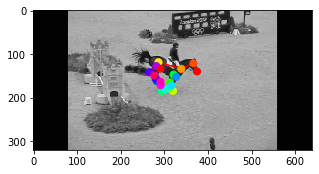

In [3]:
image, keypoints = data_generator[20]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]

cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create an augmentation pipeline

In [4]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


Load an image-keypoints pair, apply augmentation, visualize it. Rerun this cell to see multiple random augmentations.

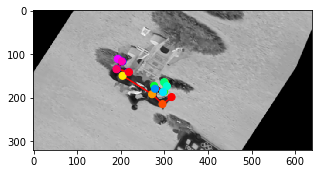

In [5]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create a `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.


In [6]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 77,
 'n_validation': 8,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (40, 80),
 'n_output_channels': 42,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'deepposekit-data/datasets/horse/annotation_data_release_modified.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 85,
 'image_shape': (320, 640, 1),
 'keypoints_shape': (20, 2)}

# Check the `TrainingGenerator` output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working and the confidence maps look good. Rerun this cell to see random augmentations. 

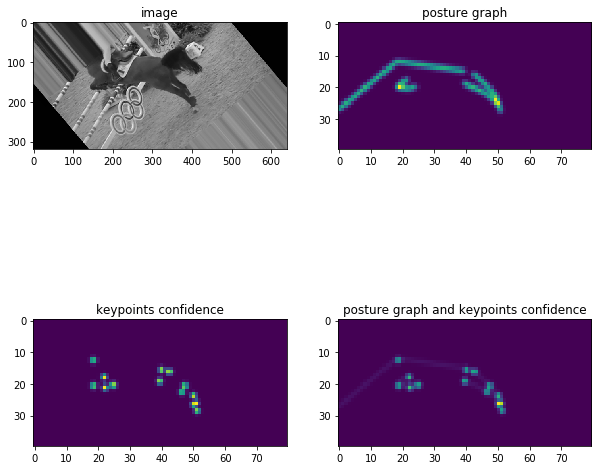

In [7]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. The `DeepLabCut` model has multiple pretrained (on ImageNet) backbones available for using transfer learning, including the original ResNet50 (He et al. 2015)  as well as the faster MobileNetV2 (Sandler et al. 2018; see  also Mathis et al. 2019) and DenseNet121 (Huang et al. 2017). We'll select `StackedDenseNet` and set `n_stacks=2` for 2 hourglasses, with `growth_rate=32` (32 filters per convolution). Adjust the `growth_rate` and/or `n_stacks` to change model performance (and speed). You can also set `pretrained=True` to use transfer learning with `StackedDenseNet`, which uses a DenseNet121 pretrained on ImageNet to encode the images.

In [8]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

You can also look at the doc strings for any of the models to get more information:

In [9]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

W1229 21:22:55.588577  6276 deprecation.py:506] From c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1229 21:23:29.184934  6276 deprecation.py:323] From c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 6,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 77,
 'n_validation': 8,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (40, 80),
 'n_output_channels': 42,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'deepposekit-data/datasets/horse/annotation_data_release_modified.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 85,
 'image_shape': (320, 640, 1),
 'keypoints_shape': (20, 2)}

# Test if GPU is available

In [10]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7263779425390240923, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3148847513
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13997236169348005894
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [ ]:
'''
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=32) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))
'''

In [11]:
data_size = (10000,) + data_generator.image_shape


# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training. You can use any callbacks available in `deepposekit.callbacks` or `tensorflow.keras.callbacks`

Remember, if you set `validation_split=0` for your `TrainingGenerator`, which will just use the training set for model fitting, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.


`Logger` evaluates the validation set (or training set if `validation_split=0` in the `TrainingGenerator`) at the end of each epoch and saves the evaluation data to a HDF5 log file (if `filepath` is set).

In [12]:
logger = Logger(validation_batch_size=2,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training.

In [13]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually.


In [35]:
model_checkpoint = ModelCheckpoint(
    filepath="D:/Projects/HorsePoseEstimation/deepposekit-data/datasets/horse/models/model_densenet_{epoch:02d}_{loss:02f}.h5",
    monitor="loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_freq='epoch',
    save_best_only=True
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment.

In [39]:
early_stop = EarlyStopping(
    monitor="loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1,
    mode='min'
)

Create a list of callbacks to pass to the model

In [40]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset.

The number of `epochs` is set to `epochs=200` for demonstration purposes. **Increase the number of epochs to train the model longer, for example `epochs=1000`**. The `EarlyStopping` callback will then automatically end training if there is no improvement. See the doc string for details:

In [38]:
history = model.fit(
            batch_size=2,
            callbacks=callbacks,
            #epochs=1000, # Increase the number of epochs to train the model longer
            epochs=200,
            n_workers=8,
            steps_per_epoch=50
)

Epoch 1/200
49/50 [============================>.] - ETA: 2s - loss: 67.6165 - output_0_loss: 22.5492 - output_1_loss: 22.5441 - output_2_loss: 22.5231
Epoch 00001: loss improved from inf to 67.79922, saving model to D:/Projects/HorsePoseEstimation/deepposekit-data/datasets/horse/models/model_densenet_01_67.799222.h5
evaluation_metrics: 
euclidean - mean: 170.99 (0%:  0.96, 5%:  4.54, 25%: 33.04, 50%: 119.33, 75%: 274.94, 95%: 509.38, 100%: 537.43) 
confidence - mean:  0.06 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.06, 75%:  0.08, 95%:  0.13, 100%:  0.22) 

50/50 [==============================] - 159s 3s/step - loss: 67.7992 - output_0_loss: 22.6093 - output_1_loss: 22.6058 - output_2_loss: 22.5842 - val_loss: 106.4128 - val_output_0_loss: 35.5254 - val_output_1_loss: 35.4868 - val_output_2_loss: 35.4007
Epoch 2/200
49/50 [============================>.] - ETA: 2s - loss: 63.5776 - output_0_loss: 21.2028 - output_1_loss: 21.1853 - output_2_loss: 21.1896
Epoch 00002: loss improved fro

Epoch 12/200
49/50 [============================>.] - ETA: 0s - loss: 57.3466 - output_0_loss: 19.4983 - output_1_loss: 18.9536 - output_2_loss: 18.8947
Epoch 00012: loss did not improve from 57.42687
evaluation_metrics: 
euclidean - mean: 153.58 (0%:  0.47, 5%:  2.61, 25%: 27.47, 50%: 132.67, 75%: 217.17, 95%: 422.81, 100%: 526.46) 
confidence - mean:  0.11 (0%:  0.03, 5%:  0.03, 25%:  0.06, 50%:  0.08, 75%:  0.13, 95%:  0.34, 100%:  0.48) 

50/50 [==============================] - 41s 813ms/step - loss: 57.4853 - output_0_loss: 19.5378 - output_1_loss: 19.0030 - output_2_loss: 18.9444 - val_loss: 110.8645 - val_output_0_loss: 37.5556 - val_output_1_loss: 36.6127 - val_output_2_loss: 36.6961
Epoch 13/200
49/50 [============================>.] - ETA: 0s - loss: 58.3858 - output_0_loss: 19.8846 - output_1_loss: 19.2895 - output_2_loss: 19.2117
Epoch 00013: loss did not improve from 57.42687
evaluation_metrics: 
euclidean - mean: 145.77 (0%:  1.12, 5%:  2.64, 25%: 13.21, 50%: 114.76, 75%

Epoch 24/200
49/50 [============================>.] - ETA: 0s - loss: 55.7073 - output_0_loss: 18.9033 - output_1_loss: 18.4345 - output_2_loss: 18.3695
Epoch 00024: loss did not improve from 48.30670
evaluation_metrics: 
euclidean - mean: 116.16 (0%:  0.60, 5%:  2.15, 25%:  7.27, 50%: 44.57, 75%: 196.70, 95%: 404.47, 100%: 537.83) 
confidence - mean:  0.20 (0%:  0.00, 5%:  0.03, 25%:  0.06, 50%:  0.12, 75%:  0.30, 95%:  0.61, 100%:  1.03) 

50/50 [==============================] - 42s 849ms/step - loss: 55.3082 - output_0_loss: 18.7641 - output_1_loss: 18.3050 - output_2_loss: 18.2391 - val_loss: 103.1941 - val_output_0_loss: 34.5403 - val_output_1_loss: 34.5689 - val_output_2_loss: 34.0848
Epoch 25/200
49/50 [============================>.] - ETA: 0s - loss: 54.6805 - output_0_loss: 18.6075 - output_1_loss: 18.0784 - output_2_loss: 17.9946
Epoch 00025: loss did not improve from 48.30670
evaluation_metrics: 
euclidean - mean: 116.17 (0%:  0.19, 5%:  2.63, 25%:  9.23, 50%: 57.11, 75%: 

AttributeError: 'StackedDenseNet' object has no attribute '_ckpt_saved_epoch'

# Load the model and resume training

This loads the saved model and passes it the augmentation pipeline and `DataGenerator` from earlier.

In [41]:

model = load_model(
    "deepposekit-data/datasets/horse/models/model_densenet_18_48.306701.h5",
    augmenter=augmenter,
    generator=data_generator,
)


W1229 22:35:06.280647  6276 deprecation.py:506] From c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1229 22:35:06.282642  6276 deprecation.py:506] From c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1229 22:35:06.283639  6276 deprecation.py:506] From c:\users\islam\anaconda3\envs\keras\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dt

To resume training, simply call `model.fit` again. We'll run it for another 30 `epochs`

In [42]:
history_continued = model.fit(
            batch_size=2,
            callbacks=callbacks,
            #epochs=1000, # Increase the number of epochs to train the model longer
            epochs=200,
            n_workers=8,
            steps_per_epoch=50
)


Epoch 1/200
49/50 [============================>.] - ETA: 0s - loss: 54.9107 - output_0_loss: 18.5209 - output_1_loss: 18.2268 - output_2_loss: 18.1631
Epoch 00001: loss did not improve from 48.30670
evaluation_metrics: 
euclidean - mean: 142.00 (0%:  0.50, 5%:  1.54, 25%:  7.43, 50%: 55.08, 75%: 254.25, 95%: 499.89, 100%: 536.98) 
confidence - mean:  0.16 (0%:  0.01, 5%:  0.03, 25%:  0.07, 50%:  0.11, 75%:  0.19, 95%:  0.52, 100%:  1.10) 

50/50 [==============================] - 52s 1s/step - loss: 54.3564 - output_0_loss: 18.3347 - output_1_loss: 18.0414 - output_2_loss: 17.9803 - val_loss: 104.3651 - val_output_0_loss: 34.6036 - val_output_1_loss: 34.8996 - val_output_2_loss: 34.8619
Epoch 2/200
49/50 [============================>.] - ETA: 0s - loss: 56.0934 - output_0_loss: 18.9599 - output_1_loss: 18.5996 - output_2_loss: 18.5339
Epoch 00002: loss did not improve from 48.30670
evaluation_metrics: 
euclidean - mean: 142.40 (0%:  0.65, 5%:  1.95, 25%:  8.83, 50%: 67.83, 75%: 265.6

Epoch 13/200
49/50 [============================>.] - ETA: 0s - loss: 44.7113 - output_0_loss: 15.5164 - output_1_loss: 14.6300 - output_2_loss: 14.5650
Epoch 00013: loss improved from 46.58092 to 44.67080, saving model to D:/Projects/HorsePoseEstimation/deepposekit-data/datasets/horse/models/model_densenet_13_44.670796.h5
evaluation_metrics: 
euclidean - mean: 139.03 (0%:  0.41, 5%:  1.96, 25%:  5.84, 50%: 69.97, 75%: 260.82, 95%: 426.46, 100%: 533.16) 
confidence - mean:  0.20 (0%:  0.01, 5%:  0.01, 25%:  0.05, 50%:  0.09, 75%:  0.23, 95%:  0.69, 100%:  0.91) 

50/50 [==============================] - 46s 915ms/step - loss: 44.6708 - output_0_loss: 15.4979 - output_1_loss: 14.6207 - output_2_loss: 14.5523 - val_loss: 99.8203 - val_output_0_loss: 33.2333 - val_output_1_loss: 33.3885 - val_output_2_loss: 33.1984
Epoch 14/200
49/50 [============================>.] - ETA: 0s - loss: 47.7921 - output_0_loss: 16.5081 - output_1_loss: 15.7214 - output_2_loss: 15.5625
Epoch 00014: loss did n

Epoch 36/200
49/50 [============================>.] - ETA: 0s - loss: 48.2928 - output_0_loss: 16.9031 - output_1_loss: 15.7612 - output_2_loss: 15.6285
Epoch 00036: loss did not improve from 40.02193
evaluation_metrics: 
euclidean - mean: 118.01 (0%:  0.74, 5%:  1.41, 25%:  4.16, 50%: 20.39, 75%: 253.93, 95%: 440.03, 100%: 530.81) 
confidence - mean:  0.25 (0%:  0.01, 5%:  0.02, 25%:  0.07, 50%:  0.23, 75%:  0.34, 95%:  0.60, 100%:  0.88) 

50/50 [==============================] - 42s 833ms/step - loss: 48.1282 - output_0_loss: 16.8566 - output_1_loss: 15.7027 - output_2_loss: 15.5689 - val_loss: 93.8465 - val_output_0_loss: 31.7262 - val_output_1_loss: 31.1139 - val_output_2_loss: 31.0064
Epoch 37/200
49/50 [============================>.] - ETA: 0s - loss: 49.7603 - output_0_loss: 17.3525 - output_1_loss: 16.2740 - output_2_loss: 16.1338
Epoch 00037: loss did not improve from 40.02193
evaluation_metrics: 
euclidean - mean: 128.34 (0%:  0.63, 5%:  2.30, 25%:  5.21, 50%: 33.53, 75%: 2

Epoch 59/200
49/50 [============================>.] - ETA: 0s - loss: 41.8141 - output_0_loss: 14.7979 - output_1_loss: 13.6048 - output_2_loss: 13.4113
Epoch 00059: loss did not improve from 36.05716
evaluation_metrics: 
euclidean - mean: 108.59 (0%:  1.21, 5%:  1.74, 25%:  4.59, 50%: 12.24, 75%: 237.30, 95%: 431.98, 100%: 510.60) 
confidence - mean:  0.26 (0%:  0.00, 5%:  0.01, 25%:  0.05, 50%:  0.24, 75%:  0.40, 95%:  0.62, 100%:  1.05) 

50/50 [==============================] - 44s 877ms/step - loss: 41.5780 - output_0_loss: 14.7303 - output_1_loss: 13.5246 - output_2_loss: 13.3231 - val_loss: 91.7136 - val_output_0_loss: 30.9226 - val_output_1_loss: 30.5260 - val_output_2_loss: 30.2650
Epoch 60/200
49/50 [============================>.] - ETA: 0s - loss: 42.3380 - output_0_loss: 14.9708 - output_1_loss: 13.7803 - output_2_loss: 13.5869
Epoch 00060: loss did not improve from 36.05716
evaluation_metrics: 
euclidean - mean: 113.77 (0%:  0.54, 5%:  1.55, 25%:  4.74, 50%: 16.01, 75%: 2

evaluation_metrics: 
euclidean - mean: 110.79 (0%:  0.23, 5%:  1.60, 25%:  3.74, 50%: 14.16, 75%: 235.31, 95%: 448.20, 100%: 530.70) 
confidence - mean:  0.27 (0%:  0.01, 5%:  0.01, 25%:  0.05, 50%:  0.23, 75%:  0.38, 95%:  0.70, 100%:  1.00) 

50/50 [==============================] - 45s 907ms/step - loss: 36.7371 - output_0_loss: 12.9972 - output_1_loss: 11.9404 - output_2_loss: 11.7995 - val_loss: 86.5750 - val_output_0_loss: 29.3308 - val_output_1_loss: 28.7540 - val_output_2_loss: 28.4902
Epoch 71/200
49/50 [============================>.] - ETA: 0s - loss: 35.3634 - output_0_loss: 12.7381 - output_1_loss: 11.4014 - output_2_loss: 11.2239
Epoch 00071: loss did not improve from 29.72752
evaluation_metrics: 
euclidean - mean: 115.70 (0%:  0.32, 5%:  1.44, 25%:  3.73, 50%: 15.21, 75%: 242.73, 95%: 468.56, 100%: 530.90) 
confidence - mean:  0.28 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.24, 75%:  0.41, 95%:  0.71, 100%:  0.99) 

50/50 [==============================] - 41s 812ms/step

49/50 [============================>.] - ETA: 0s - loss: 33.9595 - output_0_loss: 12.1984 - output_1_loss: 10.9600 - output_2_loss: 10.8010
Epoch 00082: loss did not improve from 29.72752
evaluation_metrics: 
euclidean - mean: 115.96 (0%:  0.48, 5%:  1.42, 25%:  3.98, 50%: 15.01, 75%: 246.56, 95%: 447.19, 100%: 536.56) 
confidence - mean:  0.27 (0%:  0.01, 5%:  0.01, 25%:  0.04, 50%:  0.24, 75%:  0.41, 95%:  0.67, 100%:  1.01) 

50/50 [==============================] - 41s 817ms/step - loss: 33.8671 - output_0_loss: 12.1607 - output_1_loss: 10.9333 - output_2_loss: 10.7732 - val_loss: 88.4945 - val_output_0_loss: 29.8155 - val_output_1_loss: 29.4717 - val_output_2_loss: 29.2073
Epoch 83/200
49/50 [============================>.] - ETA: 0s - loss: 33.8043 - output_0_loss: 12.1091 - output_1_loss: 10.9312 - output_2_loss: 10.7641
Epoch 00083: loss did not improve from 29.72752
evaluation_metrics: 
euclidean - mean: 117.76 (0%:  0.53, 5%:  1.36, 25%:  3.85, 50%: 14.93, 75%: 244.09, 95%: 4

Epoch 94/200
49/50 [============================>.] - ETA: 0s - loss: 28.7402 - output_0_loss: 10.3636 - output_1_loss: 9.2538 - output_2_loss: 9.1228
Epoch 00094: loss did not improve from 25.63930
evaluation_metrics: 
euclidean - mean: 114.85 (0%:  0.68, 5%:  1.40, 25%:  3.96, 50%: 14.03, 75%: 241.09, 95%: 429.61, 100%: 528.82) 
confidence - mean:  0.27 (0%:  0.01, 5%:  0.01, 25%:  0.04, 50%:  0.25, 75%:  0.40, 95%:  0.68, 100%:  1.03) 

50/50 [==============================] - 43s 851ms/step - loss: 28.6104 - output_0_loss: 10.3148 - output_1_loss: 9.2124 - output_2_loss: 9.0831 - val_loss: 87.3651 - val_output_0_loss: 29.6006 - val_output_1_loss: 29.0277 - val_output_2_loss: 28.7368
Epoch 95/200
49/50 [============================>.] - ETA: 0s - loss: 27.7411 - output_0_loss: 10.0841 - output_1_loss: 8.9149 - output_2_loss: 8.7422
Epoch 00095: loss did not improve from 25.63930
evaluation_metrics: 
euclidean - mean: 108.92 (0%:  0.69, 5%:  1.76, 25%:  3.88, 50%: 12.84, 75%: 244.60,

Epoch 106/200
49/50 [============================>.] - ETA: 0s - loss: 30.0930 - output_0_loss: 10.9552 - output_1_loss: 9.6637 - output_2_loss: 9.4741
Epoch 00106: loss did not improve from 25.63930
evaluation_metrics: 
euclidean - mean: 115.45 (0%:  0.23, 5%:  1.18, 25%:  3.55, 50%: 13.07, 75%: 244.15, 95%: 450.22, 100%: 530.15) 
confidence - mean:  0.29 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.30, 75%:  0.44, 95%:  0.70, 100%:  1.03) 

50/50 [==============================] - 45s 907ms/step - loss: 30.1378 - output_0_loss: 10.9639 - output_1_loss: 9.6824 - output_2_loss: 9.4916 - val_loss: 86.4845 - val_output_0_loss: 29.2495 - val_output_1_loss: 28.7649 - val_output_2_loss: 28.4701
Epoch 107/200
49/50 [============================>.] - ETA: 0s - loss: 31.2728 - output_0_loss: 11.3002 - output_1_loss: 10.0722 - output_2_loss: 9.9004 
Epoch 00107: loss did not improve from 25.63930
evaluation_metrics: 
euclidean - mean: 115.14 (0%:  0.30, 5%:  1.24, 25%:  3.72, 50%: 11.67, 75%: 244

Epoch 118/200
49/50 [============================>.] - ETA: 0s - loss: 39.7431 - output_0_loss: 14.3003 - output_1_loss: 12.8142 - output_2_loss: 12.6286
Epoch 00118: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00118: loss did not improve from 25.63930
evaluation_metrics: 
euclidean - mean: 115.11 (0%:  0.35, 5%:  1.22, 25%:  3.62, 50%: 12.40, 75%: 242.86, 95%: 424.41, 100%: 529.38) 
confidence - mean:  0.29 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.29, 75%:  0.42, 95%:  0.72, 100%:  1.03) 

50/50 [==============================] - 48s 965ms/step - loss: 41.0201 - output_0_loss: 14.7060 - output_1_loss: 13.2493 - output_2_loss: 13.0649 - val_loss: 86.5333 - val_output_0_loss: 29.2456 - val_output_1_loss: 28.7945 - val_output_2_loss: 28.4932
Epoch 119/200
49/50 [============================>.] - ETA: 0s - loss: 39.2811 - output_0_loss: 13.9609 - output_1_loss: 12.7462 - output_2_loss: 12.5740
Epoch 00119: loss did not improve from 25.63930
evaluation_metri

Epoch 130/200
49/50 [============================>.] - ETA: 0s - loss: 28.0867 - output_0_loss: 10.2713 - output_1_loss: 8.9862 - output_2_loss: 8.8292
Epoch 00130: loss did not improve from 25.25699
evaluation_metrics: 
euclidean - mean: 115.24 (0%:  0.35, 5%:  1.23, 25%:  3.63, 50%: 13.00, 75%: 242.86, 95%: 424.73, 100%: 529.68) 
confidence - mean:  0.30 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.30, 75%:  0.42, 95%:  0.70, 100%:  1.05) 

50/50 [==============================] - 44s 879ms/step - loss: 27.7744 - output_0_loss: 10.1565 - output_1_loss: 8.8865 - output_2_loss: 8.7314 - val_loss: 86.2583 - val_output_0_loss: 29.1128 - val_output_1_loss: 28.7267 - val_output_2_loss: 28.4188
Epoch 131/200
49/50 [============================>.] - ETA: 0s - loss: 38.5383 - output_0_loss: 13.7027 - output_1_loss: 12.5003 - output_2_loss: 12.3352
Epoch 00131: loss did not improve from 25.25699
evaluation_metrics: 
euclidean - mean: 114.91 (0%:  0.32, 5%:  1.23, 25%:  3.57, 50%: 12.96, 75%: 242

Epoch 142/200
49/50 [============================>.] - ETA: 0s - loss: 27.2714 - output_0_loss: 10.0010 - output_1_loss: 8.7438 - output_2_loss: 8.5267
Epoch 00142: loss did not improve from 25.22003
evaluation_metrics: 
euclidean - mean: 115.14 (0%:  0.48, 5%:  1.26, 25%:  3.59, 50%: 12.80, 75%: 243.06, 95%: 426.49, 100%: 530.03) 
confidence - mean:  0.30 (0%:  0.00, 5%:  0.01, 25%:  0.03, 50%:  0.29, 75%:  0.43, 95%:  0.71, 100%:  1.06) 

50/50 [==============================] - 40s 804ms/step - loss: 27.0269 - output_0_loss: 9.9213 - output_1_loss: 8.6606 - output_2_loss: 8.4450 - val_loss: 86.2750 - val_output_0_loss: 29.1385 - val_output_1_loss: 28.7314 - val_output_2_loss: 28.4050
Epoch 143/200
49/50 [============================>.] - ETA: 0s - loss: 40.3721 - output_0_loss: 14.2806 - output_1_loss: 13.1390 - output_2_loss: 12.9524
Epoch 00143: loss did not improve from 25.22003
evaluation_metrics: 
euclidean - mean: 115.53 (0%:  0.48, 5%:  1.23, 25%:  3.57, 50%: 12.84, 75%: 243.

Epoch 154/200
49/50 [============================>.] - ETA: 0s - loss: 33.0390 - output_0_loss: 11.9008 - output_1_loss: 10.6549 - output_2_loss: 10.4832
Epoch 00154: loss did not improve from 24.55798
evaluation_metrics: 
euclidean - mean: 114.85 (0%:  0.48, 5%:  1.23, 25%:  3.59, 50%: 12.71, 75%: 242.96, 95%: 425.81, 100%: 529.99) 
confidence - mean:  0.29 (0%:  0.00, 5%:  0.01, 25%:  0.04, 50%:  0.29, 75%:  0.42, 95%:  0.69, 100%:  1.06) 

50/50 [==============================] - 43s 860ms/step - loss: 34.8452 - output_0_loss: 12.4883 - output_1_loss: 11.2636 - output_2_loss: 11.0934 - val_loss: 86.1840 - val_output_0_loss: 29.1009 - val_output_1_loss: 28.7019 - val_output_2_loss: 28.3813
Epoch 155/200
49/50 [============================>.] - ETA: 0s - loss: 34.2580 - output_0_loss: 12.3085 - output_1_loss: 11.0756 - output_2_loss: 10.8739
Epoch 00155: loss did not improve from 24.55798
evaluation_metrics: 
euclidean - mean: 114.86 (0%:  0.48, 5%:  1.23, 25%:  3.63, 50%: 12.74, 75%:

KeyboardInterrupt: 